In [1]:
# %reset -f

import datetime
import gurobipy as gp
import itertools
import json
import math
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker as tck
import numpy as np
import pandas as pd
import pickle
import requests
import re
import scipy as sci
import sympy as sym
import warnings

from bs4 import BeautifulSoup
from gurobipy import GRB
from matplotlib.ticker import MultipleLocator
from numpy import sqrt, exp, log, sin, cos, pi
from numba import jit

# 全局绘图样式设置

# 整体风格
plt.style.use('default')
plt.rcParams['figure.facecolor'] = 'white'
# 字体
plt.rcParams['font.family'] = 'Times New Roman + Microsoft YaHei'
plt.rcParams['font.size'] = 13
plt.rcParams['font.weight'] = 'bold'
plt.rcParams['axes.labelweight'] = 'bold'
# 取消右侧和上方的刻度线
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.right'] = False
# 网格设置
plt.rcParams['axes.grid'] = True
plt.rcParams['grid.linestyle'] = ':'
plt.rcParams['axes.unicode_minus'] = False
# 主副刻度线
plt.rcParams['axes.linewidth'] = 1.3  # 主刻度线的粗细

plt.rcParams['xtick.major.width'] = 1.3  # x:主刻度:宽度
plt.rcParams['xtick.major.size'] = 5.3     # x:主刻度:长度
plt.rcParams['xtick.minor.width'] = 1.3  # x:副刻度:宽度
plt.rcParams['xtick.minor.size'] = 3     # x:副刻度:长度

plt.rcParams['ytick.major.width'] = 1.3  # y:主刻度:宽度
plt.rcParams['ytick.major.size'] = 5.3     # y:主刻度:长度
plt.rcParams['ytick.minor.width'] = 1.3  # y:副刻度:宽度
plt.rcParams['ytick.minor.size'] = 3     # y:副刻度:长度
# 设置使用latex
plt.rcParams['text.usetex'] = False

warnings.filterwarnings('ignore')

# %matplotlib inline
# matplotlib.use('TkAgg')


In [2]:
from sklearn.preprocessing import MinMaxScaler
gamma_c = 3.79
Pc = 100 * 1e6
Sc = 2.1
Sm = Sc / 3
eta_c = 0.25
eta_s = 0.8
tot_x = 217 * 1e9 / Pc
single_cost = Pc * gamma_c
GDP_2022 = 1203462.4


df_grid = pd.read_excel('各区块数据V3(TOPSIS).xlsx')
df_cb = pd.read_excel('各省数据.xlsx')

# # 标准化
# columns_to_normalize = ['single_Q', 'single_benifit', 'LaborCost', 'score']
# scaler = MinMaxScaler()
# # 应用标准化，并放在新的列中
# for col in columns_to_normalize:
#     new_col_name = col + '_norm'
#     df_grid[new_col_name] = scaler.fit_transform(df_grid[[col]])

grid_counts = len(df_grid)

In [3]:
## 问题三线性规划

# 创建优化问题
prob1 = gp.Model('光伏电场选址')
# 创建优化变量
x = prob1.addVars(grid_counts, lb=0, vtype=GRB.INTEGER, name='girdNum')

# 各省GDP约束
exclude_province = ['新疆维吾尔自治区','西藏自治区','青海省','甘肃省','内蒙古自治区']
for index,row in df_cb.iterrows():
    if row['省市区'] in exclude_province:
        continue
    
    province_idx = df_grid[df_grid['province']==row['省市区']].index
    prob1.addConstr(gp.quicksum(x[i] * single_cost for i in province_idx) <= row['GDP']* 1e8 * 0.01)

# 总GDP约束
prob1.addConstr(gp.quicksum(x[i] * single_cost for i in range(grid_counts)) <= GDP_2022 * 1e8 * 0.01)

# 区域面积约束
for index,row in df_grid.iterrows():
    prob1.addConstr(x[index] * Sc <= row['area'])
    prob1.addConstr(x[index] <= 25)
    
# 目标函数
obj1 = gp.LinExpr()
obj2 = gp.LinExpr()
for index,row in df_grid.iterrows():
    obj1 += x[index] * row['single_Q'] * row['score']
    obj2 += x[index] * (row['single_benifit'] - 15 * row['LaborCost'])

# 目标函数  
prob1.setObjectiveN(-obj1, 0)
prob1.setObjectiveN(-obj2, 1)

prob1.write("ModelQ1.lp")
prob1.Params.MIPgap = 5e-4
prob1.Params.TimeLimit = 50
prob1.Params.NoRelHeurTime = 0
prob1.optimize()

ans = [x[i].x for i in range(grid_counts)]
df_grid['ans'] = ans
df_grid.to_excel('各区块数据V4(ans).xlsx',index=False)


Set parameter MIPGap to value 0.0005
Set parameter TimeLimit to value 50
Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (win64 - Windows 10.0 (19044.2))

CPU model: AMD Ryzen 5 4600H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 3769 rows, 1871 columns and 5770 nonzeros
Model fingerprint: 0xdebcd5b9
Variable types: 0 continuous, 1871 integer (0 binary)
Coefficient statistics:
  Matrix range     [1e+00, 4e+08]
  Objective range  [4e+07, 2e+08]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e+01, 1e+12]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.

---------------------------------------------------------------------------
Multi-objectives: starting optimization with 2 objectives (1 combined) ...
---------------------------------------------------------------------------
--------------------------------------

In [6]:
# 计算总发电量
X = [x[i].x for i in range(grid_counts)]
single_Q = df_grid['single_Q'].to_numpy()
ans = np.dot(X, single_Q)
ans


1007094019531.2502

In [3]:
## 灵敏度分析
single_Q = df_grid['single_Q'].to_numpy()
exclude_province = ['新疆维吾尔自治区','西藏自治区','青海省','甘肃省','内蒙古自治区']
k_range = list(range(1, 101))
annual_power = []

for k in k_range:
    
    # 创建优化问题
    prob1 = gp.Model('光伏电场选址')
    # 创建优化变量
    x = prob1.addVars(grid_counts, lb=0, vtype=GRB.INTEGER, name='girdNum')
    
    # 各省GDP约束
    for index,row in df_cb.iterrows():
        if row['省市区'] in exclude_province:
            continue
        
        province_idx = df_grid[df_grid['province']==row['省市区']].index
        prob1.addConstr(gp.quicksum(x[i] * single_cost for i in province_idx) <= row['GDP']* 1e8 * 0.01)
    
    # 总GDP约束
    prob1.addConstr(gp.quicksum(x[i] * single_cost for i in range(grid_counts)) <= GDP_2022 * 1e8 * 0.01)
    
    # 区域面积约束
    for index,row in df_grid.iterrows():
        prob1.addConstr(x[index] * Sc <= row['area'])
        prob1.addConstr(x[index] <= k)
        
    # 目标函数
    obj1 = gp.LinExpr()
    obj2 = gp.LinExpr()
    for index,row in df_grid.iterrows():
        obj1 += x[index] * row['single_Q'] * row['score']
        obj2 += x[index] * (row['single_benifit'] - 15 * row['LaborCost'])
    
    # 目标函数  
    prob1.setObjectiveN(-obj1, 0)
    prob1.setObjectiveN(-obj2, 1)
    prob1.Params.OutputFlag = 0
    prob1.Params.MIPgap = 5e-4
    prob1.Params.TimeLimit = 50
    prob1.Params.NoRelHeurTime = 0
    prob1.optimize()
    
    # 计算总发电量
    X = [x[i].x for i in range(grid_counts)]
    ans = np.dot(X, single_Q)
    annual_power.append(ans)
    
    print(f'k={k}, 年发电量={ans}')


k=1, 年发电量=520251848593.75
k=2, 年发电量=903558036718.75
k=3, 年发电量=942714080000.0
k=4, 年发电量=957736538281.25
k=5, 年发电量=963824421875.0
k=6, 年发电量=966573424687.5
k=7, 年发电量=971003770625.0
k=8, 年发电量=973092095937.5
k=9, 年发电量=975214171093.75
k=10, 年发电量=979457374218.75
k=11, 年发电量=981106225312.5
k=12, 年发电量=984985835312.5
k=13, 年发电量=986789263906.25
k=14, 年发电量=989031976406.25
k=15, 年发电量=991070500000.0
k=16, 年发电量=992431430156.25
k=17, 年发电量=995157423750.0002
k=18, 年发电量=996473086875.0002
k=19, 年发电量=998911875937.5002
k=20, 年发电量=1001789075000.0
k=21, 年发电量=1002103998437.5001
k=22, 年发电量=1002711737343.7501
k=23, 年发电量=1004094729531.25
k=24, 年发电量=1005428627656.2501
k=25, 年发电量=1007094019531.2502
k=26, 年发电量=1008989882031.2502
k=27, 年发电量=1008833706562.5002
k=28, 年发电量=1009626474062.5002
k=29, 年发电量=1008577661875.0
k=30, 年发电量=1010388400000.0
k=31, 年发电量=1012020516718.7502
k=32, 年发电量=1014154678906.2502
k=33, 年发电量=1016097376875.0002
k=34, 年发电量=1018423375156.2502
k=35, 年发电量=1019078279843.7504
k=36, 年发电量=1018573291093.7502

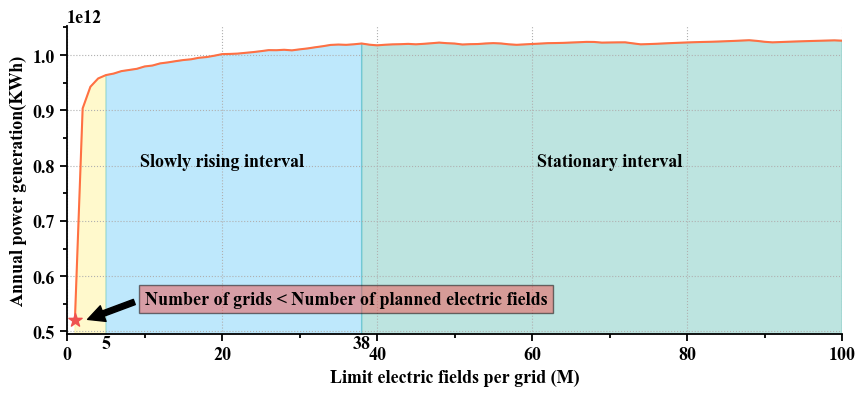

In [5]:
# 绘图

k_range = np.array(k_range)
y_max = np.array([1.1] * len(k_range))
fig, ax = plt.subplots(figsize=(10,4))
ax.plot(k_range, annual_power,color='#FF7043')
ax.scatter(k_range[0], annual_power[0], s=100, marker='*',zorder=2,color='#EF5350')
ax.set_xlim([0,100])
ax.set_ylim()
ax.set_xlabel('Limit electric fields per grid (M)')
ax.set_ylabel('Annual power generation(KWh)')
ax.xaxis.set_minor_locator(tck.AutoMinorLocator(n=2))
ax.yaxis.set_minor_locator(tck.AutoMinorLocator(n=2))

# 添加颜色区间
ax.fill_between(k_range, annual_power, where=(k_range >= 1) & (k_range <= 5), color='#FFEE58', alpha=0.3)
ax.fill_between(k_range, annual_power, where=(k_range >= 5) & (k_range <= 38), color='#29B6F6', alpha=0.3)
ax.fill_between(k_range, annual_power, where=(k_range >= 38) & (k_range <= 100), color='#26A69A', alpha=0.3)

# Add text next to the point [k_range[0],annual_power[0]] enclosed in a box
# 使用annotate函数必备参数绘制注解
bbox = {"facecolor": "#EF5350", "alpha": 0.5}
styles = {"size": 13, "color": "black", "bbox": bbox}
ax.text(10, 0.55 * 1e12, "Number of grids < Number of planned electric fields", **styles)
ax.text(20, 0.8 * 1e12,"Slowly rising interval", ha="center")
ax.text(70, 0.8 * 1e12,"Stationary interval",ha="center")
ax.text(5, 0.47 * 1e12,"5",ha="center")
ax.text(38, 0.47 * 1e12,"38",ha="center")
ax.annotate('', xytext=(9, 0.555 * 1e12), xy=(2.3, 0.52 * 1e12), arrowprops=dict(facecolor='black', shrink=0.05))
plt.savefig('网格最大电场图.pdf', bbox_inches='tight')